# Matplotlib a Vega-Lite: Conversión Automática

Este notebook muestra cómo detectar automáticamente el tipo de gráfico de Matplotlib y convertirlo a una especificación Vega-Lite, que puede ser utilizada con Altair.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import altair as alt
import json
from pprint import pprint

# Función para detectar el tipo de gráfico en un objeto Axes de Matplotlib
def detect_plot_type(ax):
    """
    Detecta el tipo de gráfico en un objeto Axes de Matplotlib.
    Retorna una cadena con el tipo de gráfico detectado.
    """
    # Verificar en los contenedores si hay algún histograma
    if hasattr(ax, 'containers') and ax.containers:
        for container in ax.containers:
            if type(container).__name__ == 'BarContainer':
                # Si el contenedor tiene "hist" en la etiqueta o si es un contenedor de barras
                # y las barras tienen anchos similares, es probable que sea un histograma
                if hasattr(container, 'get_label') and 'hist' in container.get_label().lower():
                    return 'histogram'
    
    # Verificar gráficos de dispersión (PathCollection)
    if hasattr(ax, 'collections') and ax.collections:
        for collection in ax.collections:
            if type(collection).__name__ == 'PathCollection':
                return 'scatter'
    
    # Verificar gráficos de líneas (Line2D)
    if hasattr(ax, 'lines') and ax.lines:
        return 'line'
    
    # Verificar gráficos de barras y histogramas (Rectangle patches)
    if hasattr(ax, 'patches') and ax.patches:
        if all(type(patch).__name__ == 'Rectangle' for patch in ax.patches):
            # Diferenciar entre histogramas y gráficos de barras
            # Los histogramas suelen tener barras de igual anchura y muchos más elementos
            patch_widths = [patch.get_width() for patch in ax.patches]
            
            # Criterios para identificar un histograma:
            # 1. Muchas barras (> 5)
            # 2. Ancho de barras consistente (pocos valores únicos)
            # 3. Barras adyacentes sin espacios
            
            if len(patch_widths) > 5:
                unique_widths = len(set(round(w, 5) for w in patch_widths))
                
                # Si la mayoría de los anchos son iguales (con una pequeña tolerancia)
                if unique_widths <= 3:
                    # Verificar si las barras son adyacentes (criterio adicional para histogramas)
                    x_positions = sorted([patch.get_x() for patch in ax.patches])
                    adjacent = all(
                        abs((x_positions[i+1] - (x_positions[i] + patch_widths[i]))) < 1e-5
                        for i in range(len(x_positions)-1)
                    )
                    
                    if adjacent:
                        return 'histogram'
            
            # Si no cumple criterios de histograma, es un gráfico de barras
            return 'bar'
    
    # Si no se puede determinar, devolver desconocido
    return 'unknown'

# Función para extraer datos de un objeto Axes según el tipo de gráfico
def extract_data_from_axes(ax, plot_type):
    """
    Extrae los datos relevantes de un objeto Axes según el tipo de gráfico.
    Retorna un diccionario con los datos extraídos.
    """
    data = {}
    
    if plot_type == 'scatter':
        if hasattr(ax, 'collections') and ax.collections:
            for i, collection in enumerate(ax.collections):
                if type(collection).__name__ == 'PathCollection':
                    # Extraer coordenadas x, y
                    offsets = collection.get_offsets()
                    x_data = offsets[:, 0]
                    y_data = offsets[:, 1]
                    
                    # Extraer tamaños si están disponibles
                    sizes = collection.get_sizes()
                    if len(sizes) == 1 and len(x_data) > 1:
                        sizes = [sizes[0]] * len(x_data)
                    
                    # Extraer colores si están disponibles
                    colors = collection.get_facecolors()
                    if len(colors) == 1 and len(x_data) > 1:
                        colors = [colors[0]] * len(x_data)
                    
                    # Crear etiqueta
                    label = collection.get_label() or f'series_{i}'
                    labels = [label] * len(x_data)
                    
                    # Guardar datos
                    data.setdefault('x', []).extend(x_data)
                    data.setdefault('y', []).extend(y_data)
                    data.setdefault('size', []).extend(sizes)
                    data.setdefault('label', []).extend(labels)
    
    elif plot_type == 'line':
        if hasattr(ax, 'lines') and ax.lines:
            for i, line in enumerate(ax.lines):
                x_data = line.get_xdata()
                y_data = line.get_ydata()
                label = line.get_label() or f'series_{i}'
                labels = [label] * len(x_data)
                
                # Guardar datos
                data.setdefault('x', []).extend(x_data)
                data.setdefault('y', []).extend(y_data)
                data.setdefault('label', []).extend(labels)
    
    elif plot_type == 'bar':
        if hasattr(ax, 'patches') and ax.patches:
            x_data = []
            y_data = []
            width_data = []
            height_data = []
            
            for patch in ax.patches:
                # Para gráficos de barras, extraer posición x, altura y, ancho
                x = patch.get_x()
                y = patch.get_y()
                width = patch.get_width()
                height = patch.get_height()
                
                x_data.append(x + width/2)  # Centro de la barra
                y_data.append(height)
                width_data.append(width)
                height_data.append(height)
            
            # Guardar datos
            data['x'] = x_data
            data['y'] = y_data
            data['width'] = width_data
            data['height'] = height_data
            data['label'] = ['bars'] * len(x_data)
    
    elif plot_type == 'histogram':
        if hasattr(ax, 'patches') and ax.patches:
            # Para histogramas, necesitamos extraer los bordes de los bins y las alturas
            edges = []  # Almacena los bordes de los bins
            heights = []  # Almacena las alturas
            
            for patch in ax.patches:
                x = patch.get_x()
                width = patch.get_width()
                height = patch.get_height()
                
                # Guardar el borde izquierdo y la altura
                edges.append(x)
                heights.append(height)
                
                # Para el último bin, también necesitamos el borde derecho
                if len(edges) == len(ax.patches):
                    edges.append(x + width)
            
            # Crear valores x para representar el centro de cada bin
            x_centers = [(edges[i] + edges[i+1])/2 for i in range(len(edges)-1)]
            
            # Guardar datos
            data['bin_start'] = edges[:-1]
            data['bin_end'] = edges[1:]
            data['x'] = x_centers
            data['y'] = heights
            data['count'] = heights  # Para mantener consistencia con Vega-Lite
            data['label'] = ['histogram'] * len(heights)
    
    return data

# Función para crear una especificación Vega-Lite a partir de los datos extraídos
def create_vega_lite_spec(fig, ax):
    """
    Crea una especificación Vega-Lite a partir de un objeto figura y axes de Matplotlib.
    """
    # Detectar el tipo de gráfico
    plot_type = detect_plot_type(ax)
    print(f"Tipo de gráfico detectado: {plot_type}")
    
    # Extraer datos según el tipo de gráfico
    data = extract_data_from_axes(ax, plot_type)
    
    if not data:
        raise ValueError(f"No se pudieron extraer datos para el tipo de gráfico: {plot_type}")
    
    # Convertir a DataFrame para Altair
    df = pd.DataFrame(data)
    
    # Crear la especificación Vega-Lite según el tipo de gráfico
    if plot_type == 'scatter':
        chart = alt.Chart(df).mark_circle().encode(
            x='x',
            y='y',
            size='size' if 'size' in df.columns else alt.value(40),
            color='label'
        ).properties(
            title=ax.get_title(),
            width=400,
            height=300
        )
    
    elif plot_type == 'line':
        chart = alt.Chart(df).mark_line().encode(
            x='x',
            y='y',
            color='label'
        ).properties(
            title=ax.get_title(),
            width=400,
            height=300
        )
    
    elif plot_type == 'bar':
        chart = alt.Chart(df).mark_bar().encode(
            x=alt.X('x', title=ax.get_xlabel() or 'X'),
            y=alt.Y('y', title=ax.get_ylabel() or 'Y'),
            color='label'
        ).properties(
            title=ax.get_title(),
            width=400,
            height=300
        )
    
    elif plot_type == 'histogram':
        # Crear un histograma usando los datos ya agregados
        chart = alt.Chart(df).mark_bar().encode(
            x=alt.X('x', title=ax.get_xlabel() or 'X',
                  scale=alt.Scale(domain=[df['bin_start'].min(), df['bin_end'].max()]),
                  axis=alt.Axis(tickCount=min(20, len(df)))),
            y=alt.Y('y', title=ax.get_ylabel() or 'Frecuencia'),
            tooltip=[
                alt.Tooltip('bin_start', title='Inicio', format='.2f'),
                alt.Tooltip('bin_end', title='Fin', format='.2f'),
                alt.Tooltip('count', title='Frecuencia')
            ]
        ).properties(
            title=ax.get_title(),
            width=400,
            height=300
        )
    
    else:
        raise ValueError(f"No se admite la conversión para el tipo de gráfico: {plot_type}")
    
    return chart

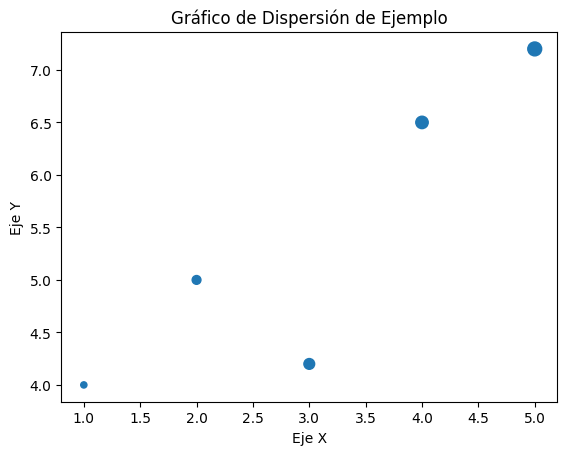

Tipo de gráfico detectado: scatter


alt.Chart(...)

In [8]:
# Crear un gráfico de dispersión de ejemplo con Matplotlib
fig, ax = plt.subplots()

# Generar datos
np.random.seed(42)
x = np.array([1, 2, 3, 4, 5])
y = np.array([4, 5, 4.2, 6.5, 7.2])
sizes = np.array([20, 40, 60, 80, 100])

# Crear un gráfico de dispersión
scatter = ax.scatter(x, y, s=sizes)

ax.set_title('Gráfico de Dispersión de Ejemplo')
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')

# Mostrar el gráfico de Matplotlib
plt.show()

# Convertir a Vega-Lite
vega_lite_spec = create_vega_lite_spec(fig, ax)

# Mostrar el gráfico de Vega-Lite
vega_lite_spec

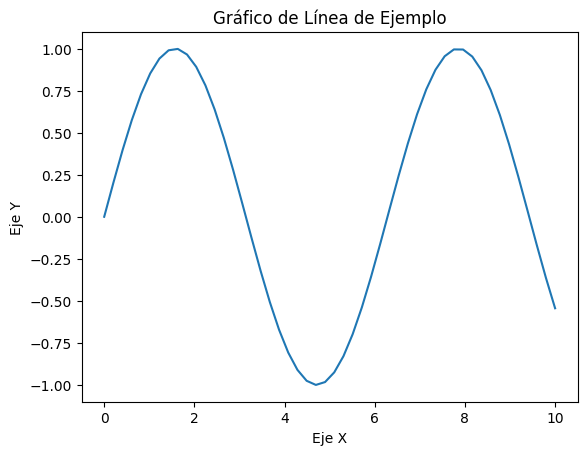

Tipo de gráfico detectado: line


alt.Chart(...)

In [9]:
# Ejemplo con un gráfico de líneas
fig, ax = plt.subplots()

# Generar datos
x = np.linspace(0, 10, 50)
y = np.sin(x)

# Crear un gráfico de líneas
line = ax.plot(x, y)

ax.set_title('Gráfico de Línea de Ejemplo')
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')

# Mostrar el gráfico de Matplotlib
plt.show()

# Convertir a Vega-Lite
vega_lite_spec = create_vega_lite_spec(fig, ax)

# Mostrar el gráfico de Vega-Lite
vega_lite_spec

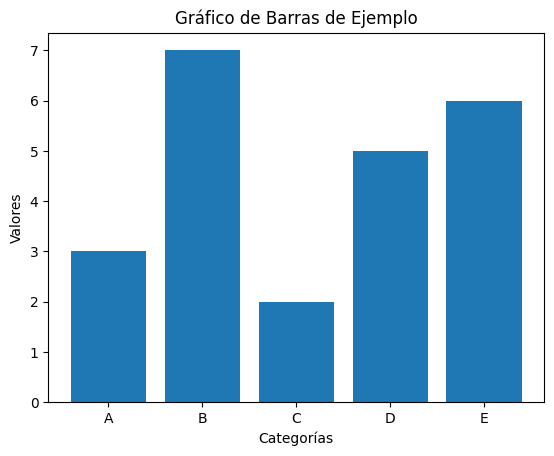

Tipo de gráfico detectado: bar


alt.Chart(...)

In [10]:
# Ejemplo con un gráfico de barras
fig, ax = plt.subplots()

# Generar datos
categories = ['A', 'B', 'C', 'D', 'E']
values = [3, 7, 2, 5, 6]

# Crear un gráfico de barras
bars = ax.bar(categories, values)

ax.set_title('Gráfico de Barras de Ejemplo')
ax.set_xlabel('Categorías')
ax.set_ylabel('Valores')

# Mostrar el gráfico de Matplotlib
plt.show()

# Convertir a Vega-Lite
vega_lite_spec = create_vega_lite_spec(fig, ax)

# Mostrar el gráfico de Vega-Lite
vega_lite_spec

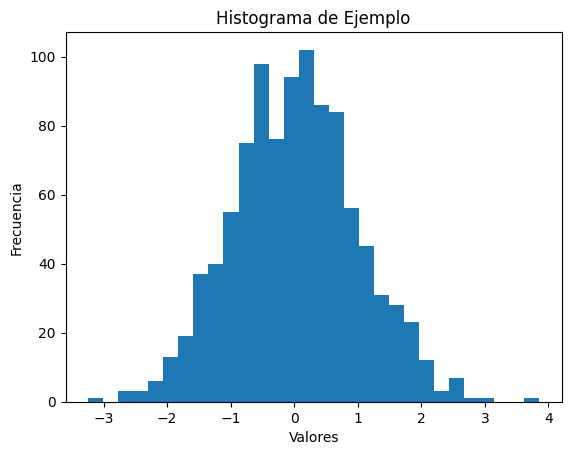

Tipo de gráfico detectado: histogram


alt.Chart(...)

In [11]:
# Ejemplo con un histograma
fig, ax = plt.subplots()

# Generar datos
data = np.random.normal(0, 1, 1000)

# Crear un histograma
hist = ax.hist(data, bins=30)

ax.set_title('Histograma de Ejemplo')
ax.set_xlabel('Valores')
ax.set_ylabel('Frecuencia')

# Mostrar el gráfico de Matplotlib
plt.show()

# Convertir a Vega-Lite
vega_lite_spec = create_vega_lite_spec(fig, ax)

# Mostrar el gráfico de Vega-Lite
vega_lite_spec

## Guardar las Especificaciones Vega-Lite

Puedes guardar las especificaciones Vega-Lite a archivos JSON para usarlas en aplicaciones web o para compartirlas.

In [12]:
# Guardar la especificación Vega-Lite a un archivo JSON
vega_lite_spec.save('vega_lite_chart.json')

# Leer el archivo JSON y mostrar el contenido
with open('vega_lite_chart.json', 'r') as f:
    spec_json = json.load(f)
    pprint(spec_json)

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json',
 'config': {'view': {'continuousHeight': 300, 'continuousWidth': 400}},
 'data': {'name': 'data-a1b3cdeeb655a92237c3f075924a91f5'},
 'datasets': {'data-a1b3cdeeb655a92237c3f075924a91f5': [{'bin_end': -3.0048007123782794,
                                                         'bin_start': -3.241267340069073,
                                                         'count': 1.0,
                                                         'label': 'histogram',
                                                         'x': -3.123034026223676,
                                                         'y': 1.0},
                                                        {'bin_end': -2.7683340846874867,
                                                         'bin_start': -3.0048007123782794,
                                                         'count': 0.0,
                                                         'label': 'his

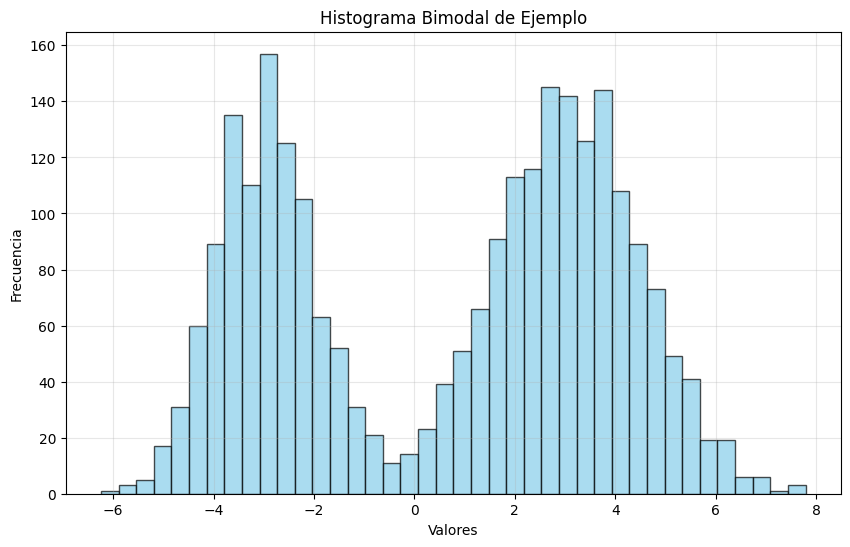

Tipo de gráfico detectado: histogram


alt.Chart(...)

In [13]:
# Ejemplo con un histograma más complejo (distribución bimodal)
fig, ax = plt.subplots(figsize=(10, 6))

# Generar datos con distribución bimodal
np.random.seed(42)
data1 = np.random.normal(-3, 1, 1000)
data2 = np.random.normal(3, 1.5, 1500)
combined_data = np.concatenate([data1, data2])

# Crear histograma con diferentes opciones
hist = ax.hist(combined_data, bins=40, alpha=0.7, color='skyblue', edgecolor='black')

ax.set_title('Histograma Bimodal de Ejemplo')
ax.set_xlabel('Valores')
ax.set_ylabel('Frecuencia')
ax.grid(True, alpha=0.3)

# Mostrar el gráfico de Matplotlib
plt.show()

# Convertir a Vega-Lite e imprimir tipo detectado
vega_lite_spec = create_vega_lite_spec(fig, ax)

# Mostrar el gráfico de Vega-Lite
vega_lite_spec

In [14]:
# Para exploración y depuración:
# Verificar la estructura del histograma de Matplotlib
def examine_histogram(ax):
    """Examina y muestra información detallada sobre un histograma en Matplotlib"""
    # Verificar si existe objeto de histograma
    print("Explorando estructura del histograma...")
    
    # Verificar colecciones
    if hasattr(ax, 'collections') and ax.collections:
        print(f"Colecciones: {len(ax.collections)} encontradas")
        for i, coll in enumerate(ax.collections):
            print(f"  Colección {i}: {type(coll).__name__}")
    else:
        print("No se encontraron colecciones")
    
    # Verificar patches (normalmente las barras del histograma)
    if hasattr(ax, 'patches') and ax.patches:
        print(f"Patches: {len(ax.patches)} encontrados")
        for i, patch in enumerate(ax.patches[:3]):  # Solo muestra los primeros 3
            print(f"  Patch {i}: {type(patch).__name__}")
            print(f"    x={patch.get_x():.2f}, y={patch.get_y():.2f}, width={patch.get_width():.2f}, height={patch.get_height():.2f}")
        
        # Analizar distribución de anchos
        widths = [patch.get_width() for patch in ax.patches]
        print(f"  Ancho mínimo: {min(widths):.4f}, máximo: {max(widths):.4f}")
        print(f"  Valores únicos de ancho: {len(set([round(w, 5) for w in widths]))}")
    else:
        print("No se encontraron patches")
        
    # Verificar si existe n, bins, patches de hist
    for key in dir(ax):
        if key.startswith('_') and 'hist' in key:
            print(f"Encontrada propiedad potencial de histograma: {key}")
            
    # Verificar contenedores
    if hasattr(ax, 'containers') and ax.containers:
        print(f"Contenedores: {len(ax.containers)} encontrados")
        for i, container in enumerate(ax.containers):
            print(f"  Contenedor {i}: {type(container).__name__} con {len(container)} elementos")
    else:
        print("No se encontraron contenedores")

# Crear un nuevo histograma para examinar
fig, ax = plt.subplots()
hist = ax.hist(np.random.normal(0, 1, 1000), bins=20)
plt.close()  # No mostrar

# Examinar estructura
examine_histogram(ax)

Explorando estructura del histograma...
No se encontraron colecciones
Patches: 20 encontrados
  Patch 0: Rectangle
    x=-2.99, y=0.00, width=0.35, height=5.00
  Patch 1: Rectangle
    x=-2.65, y=0.00, width=0.35, height=6.00
  Patch 2: Rectangle
    x=-2.30, y=0.00, width=0.35, height=17.00
  Ancho mínimo: 0.3459, máximo: 0.3459
  Valores únicos de ancho: 1
Contenedores: 1 encontrados
  Contenedor 0: BarContainer con 20 elementos
